In [4]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch import optim
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Dict
from tqdm import tqdm
%matplotlib inline

### Dataset

In [5]:
# trainset = FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
# testset = FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

trainset = MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
testset = MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 99142515.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27424879.74it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22426451.03it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1489952.20it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [3]:
classes = {i : name for i, name in enumerate(trainset.classes)}
classes

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

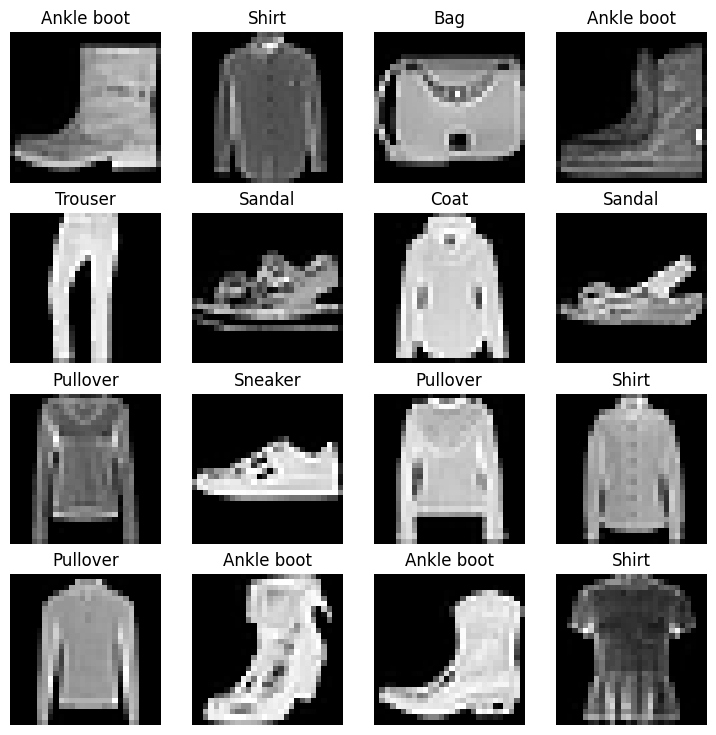

In [4]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    idx = torch.randint(0, len(trainset), size=[1]).item()
    img, label = trainset[idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(classes[label])
    plt.axis(False)

In [5]:
BATCH_SIZE = 8
NUM_WORKERS = 2
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
testloader  = DataLoader(dataset= testset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
imgs, labels = next(iter(trainloader))

### Variational Autoencoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_shape: int, hidden_units:Tuple=(32, 64, 128)) -> None:
        super(Encoder, self).__init__()
        assert len(hidden_units) == 3, "hidden_units must be 3 dimensional"
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                        out_channels=hidden_units[0],
                        kernel_size=3,
                        padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=hidden_units[0],
                        out_channels=hidden_units[1],
                        kernel_size=3,
                        padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=hidden_units[1],
                        out_channels=hidden_units[2],
                        kernel_size=3,
                        padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        out = self.conv_block(input)
        self.out_shape = out.shape[1:]
        out = nn.Flatten()(out)
        return out

In [14]:
class LatentSpace(nn.Module):
    def __init__(self, in_features: int, dims: int) -> None:
        super(LatentSpace, self).__init__()
        self.dims = dims
        self.z_mean_layer = nn.Linear(in_features=in_features,out_features=dims)
        self.z_log_var_layer = nn.Linear(in_features=in_features, out_features=dims)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        z_mean = self.z_mean_layer(input)
        z_log_var = self.z_log_var_layer(input)
        z_sigma = (z_log_var * 0.5).exp()
        eps = torch.randn_like(z_sigma)
        z = z_mean + z_sigma * eps
        return z_mean, z_log_var, z

In [15]:
class Decoder(nn.Module):
    def __init__(self, dims: int, enc_shape: Tuple, hidden_units:Tuple=(32, 64, 128)) -> None:
        super(Decoder, self).__init__()
        self.convt_block = nn.Sequential(
            nn.Linear(in_features=dims, out_features=np.prod(enc_shape)),
            nn.Unflatten(dim=1, unflattened_size=enc_shape),
            nn.ConvTranspose2d(in_channels=hidden_units[-1],
                               out_channels=hidden_units[-2],
                               kernel_size=3,
                               stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units[-2],
                               out_channels=hidden_units[-1],
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=hidden_units[-1],
                               out_channels=1,
                               kernel_size=3,
                               stride=2,
                               padding=1,
                               output_padding=1),
            nn.ReLU(),
            # decoder output
            nn.Conv2d(in_channels=1,
                      out_channels=1,
                      kernel_size=3,
                      padding='same'),
            nn.Sigmoid())

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.convt_block(input)

In [16]:
class ConditionalVAE(nn.Module):
    def __init__(self, encoder, decoder, latentspace, classes: Dict) -> None:
        super(ConditionalVAE, self).__init__()
        self.classes = classes

        self.encoder = encoder
        self.decoder = decoder
        self.latentspace = latentspace
        self.cls_embedding = nn.Embedding(len(classes), latentspace.dims)
        # self.cls_linear = nn.Linear(len(classes), self.latentspace.dims)

    def forward(self, imgs: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        enc_out = self.encoder(imgs)
        z_mean, z_log_var, z = self.latentspace(enc_out)
        dec_in = z + self.cls_embedding(labels)
        dec_out = self.decoder(dec_in)
        return z_mean, z_log_var, dec_out

    def generate(self, labels: torch.Tensor) -> torch.Tensor:
        cls_projection = self.cls_embedding(labels)
        device = cls_projection.get_device()
        z = torch.randn_like(cls_projection)
        return self.decoder(z + cls_projection)


### Training

In [22]:
def loss_fn(reconstruction, original, z_mean, z_log_var):
    BCE = nn.BCELoss(reduction='sum')(reconstruction, original)
    KLD = -0.5 * (1 + z_log_var - z_mean ** 2 - z_log_var.exp()).sum()
    total = BCE + KLD
    return BCE, KLD, total

def update_results(storage: Dict, results: Dict):
    for key in results:
        storage[key].append(results[key])

def show_imgs(imgs, labels):
    # imgs, labels = imgs.to('cpu').detach().numpy(), labels.to('cpu').detach().numpy()
    fig = plt.figure(figsize=(8,4))
    rows, cols = 2, 4
    for i in range(rows*cols):
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(imgs[i].squeeze(), cmap='gray')
        plt.title(classes[labels[i].item()])
        plt.axis(False)
    plt.show();

In [25]:
def train_step(model: nn.Module, dataloader: DataLoader,
               loss_fn: callable, optimizer: optim.Optimizer,
               device: torch.device, metric_fn: callable) -> Dict:

    model.train()

    total_loss, bce_loss, kld_loss, metric = .0, .0, .0, .0

    for i, (X, y) in enumerate(tqdm(dataloader)):
        X, y = X.to(device), y.to(device)
        z_mean, z_log_var, reconstruction = model(X, y)
        if i % 500 == 0:
            rand_labels = torch.randint(0, 10, (8,)).to(device)
            gen_imgs = model.generate(rand_labels)
            gen_imgs = gen_imgs.to('cpu').detach().numpy()
            rand_labels = rand_labels.to('cpu').detach().numpy()
            show_imgs(gen_imgs, rand_labels)
            # show_imgs(reconstruction, y)
            print(gen_imgs[0].min().item(), reconstruction[0].max().item())

        bce, kld, batch_loss = loss_fn(reconstruction, X, z_mean, z_log_var)

        total_loss += batch_loss.item()
        bce_loss += bce.item()
        kld_loss += kld.item()
        # metric += ...

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    total_loss /= len(dataloader)
    bce_loss /= len(dataloader)
    kld_loss /= len(dataloader)
    metric /= len(dataloader)

    return {'total_loss': total_loss,
            'bce_loss': bce_loss,
            'kld_loss': kld_loss,
            'metric': metric}


def test_step(model: nn.Module, dataloader: DataLoader,
              loss_fn: callable, device: torch.device,
              metric_fn: callable) -> Dict:

    total_loss, bce_loss, kld_loss, metric = .0, .0, .0, .0

    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            z_mean, z_log_var, reconstruction = model(X, y)
            bce, kld, batch_loss = loss_fn(reconstruction, X, z_mean, z_log_var)

            total_loss += batch_loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()

    total_loss /= len(dataloader)
    bce_loss /= len(dataloader)
    kld_loss /= len(dataloader)
    metric /= len(dataloader)

    return {'total_loss': total_loss,
            'bce_loss': bce_loss,
            'kld_loss': kld_loss,
            'metric': metric}


def train(model: nn.Module, train_dataloader: DataLoader,
          test_dataloader: DataLoader, loss_fn: callable,
          optimizer: optim.Optimizer, device: torch.device,
          EPOCHS: int, metric_fn: callable):

    model = model.to(device)
    columns = ['total_loss', 'bce_loss', 'kld_loss', 'metric']
    train_results = {key:[] for key in columns}
    test_results = {key:[] for key in columns}

    for epoch in range(EPOCHS):
        print(f"Epoch {epoch + 1}/{EPOCHS} - Training:")

        results = train_step(model, train_dataloader, loss_fn,
                                  optimizer, device, metric_fn)

        update_results(train_results, results)
        print(f"  Train Loss: {results['total_loss']:.4f}")

        print("  Testing:")
        results = test_step(model, test_dataloader, loss_fn,
                                 device, metric_fn)

        update_results(test_results, results)
        print(f"  Test Loss: {results['total_loss']:.4f}")

        # rand_labels = torch.randint(0, 10, (8,)).to(device)
        # gen_imgs = model.generate(rand_labels)
        # gen_imgs = gen_imgs.to('cpu').detach().numpy()
        # rand_labels = rand_labels.to('cpu').detach().numpy()
        # show_imgs(gen_imgs, rand_labels)

    return train_results, test_results

Epoch 1/5 - Training:


  0%|          | 0/7500 [00:00<?, ?it/s]

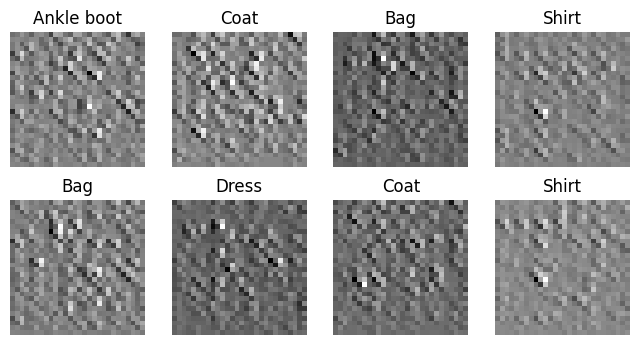

  0%|          | 6/7500 [00:00<16:01,  7.79it/s]  

0.49560850858688354 0.5423144102096558


  7%|▋         | 500/7500 [00:05<00:52, 132.80it/s]

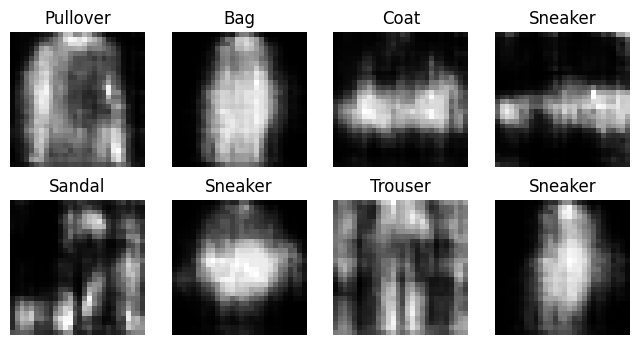

  7%|▋         | 514/7500 [00:05<02:01, 57.35it/s] 

0.00037078739842399955 0.6607041954994202


 13%|█▎        | 991/7500 [00:09<00:46, 140.51it/s]

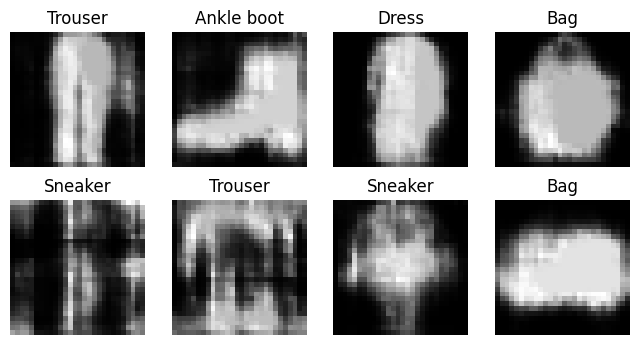

 14%|█▎        | 1022/7500 [00:09<01:23, 78.03it/s]

0.0001228206674568355 0.70351243019104


 20%|█▉        | 1499/7500 [00:13<00:41, 145.55it/s]

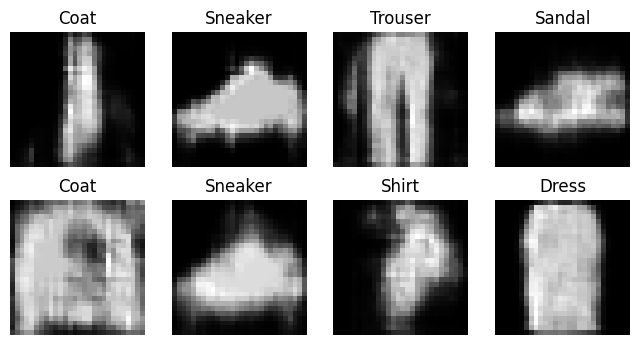

 20%|██        | 1514/7500 [00:13<01:36, 62.29it/s] 

1.5572839242097847e-12 0.5579965114593506


 26%|██▋       | 1987/7500 [00:17<00:38, 141.98it/s]

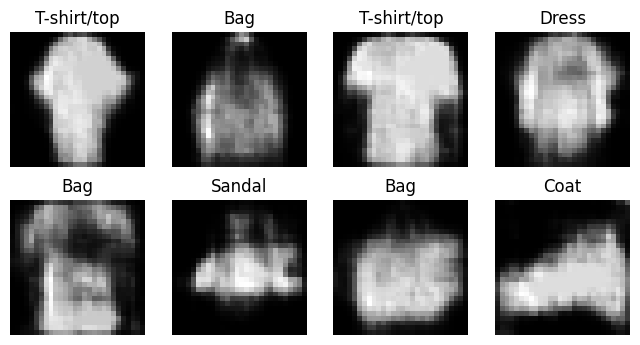

 27%|██▋       | 2015/7500 [00:18<01:39, 55.08it/s]

2.1274112679825485e-11 0.6760018467903137


 33%|███▎      | 2496/7500 [00:22<00:35, 140.52it/s]

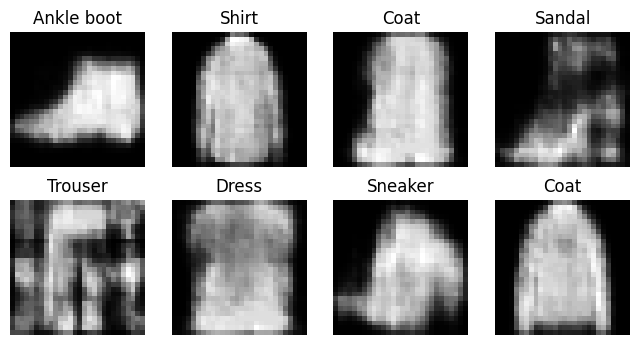

 34%|███▎      | 2525/7500 [00:22<01:09, 71.59it/s]

2.1843836961465968e-08 0.6141317486763


 40%|███▉      | 2999/7500 [00:26<00:31, 141.23it/s]

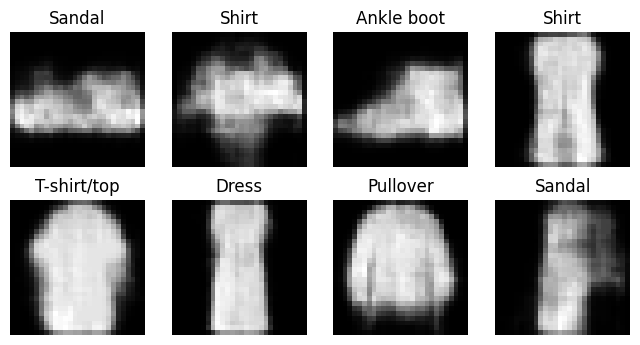

 40%|████      | 3014/7500 [00:26<01:13, 61.02it/s] 

1.7644205172473448e-06 0.8192341327667236


 47%|████▋     | 3489/7500 [00:30<00:29, 136.13it/s]

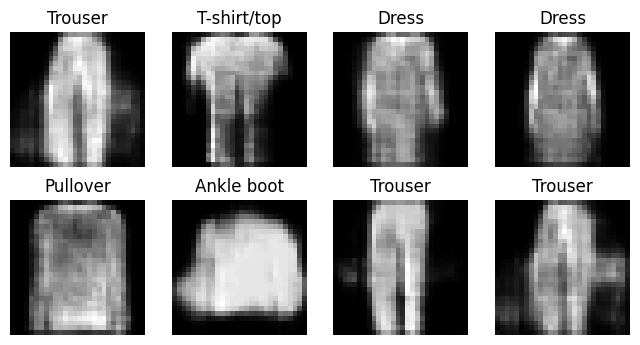

 47%|████▋     | 3518/7500 [00:31<00:53, 74.55it/s]

8.284044270112645e-06 0.7680411338806152


 53%|█████▎    | 3997/7500 [00:34<00:24, 142.96it/s]

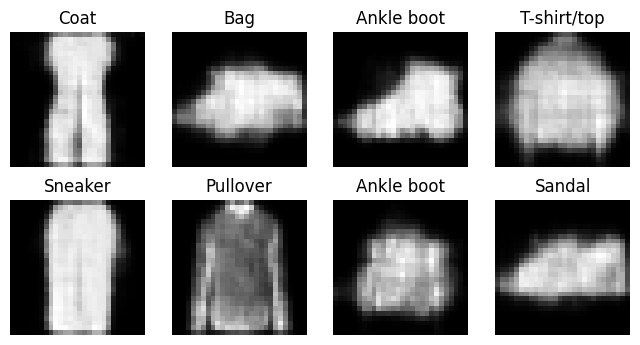

 54%|█████▎    | 4027/7500 [00:35<00:47, 73.75it/s]

1.0567017096410614e-12 0.8322054147720337


 60%|█████▉    | 4488/7500 [00:38<00:21, 141.98it/s]

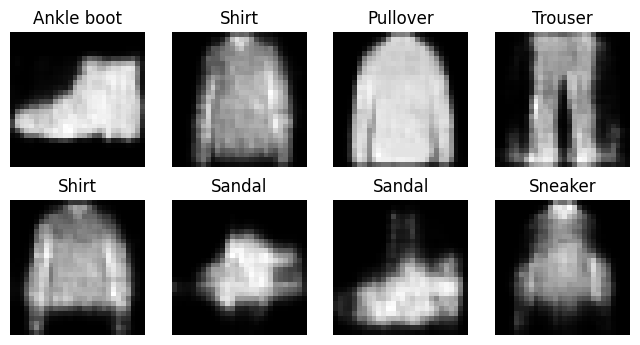

 60%|██████    | 4514/7500 [00:39<00:50, 59.40it/s]

4.8355857512616396e-11 0.8872097134590149


 67%|██████▋   | 4989/7500 [00:43<00:18, 139.23it/s]

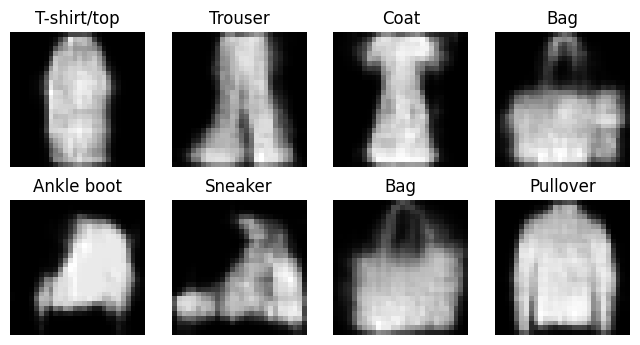

 67%|██████▋   | 5016/7500 [00:44<00:43, 57.27it/s]

7.056741302413627e-11 0.9140693545341492


 73%|███████▎  | 5493/7500 [00:47<00:14, 142.58it/s]

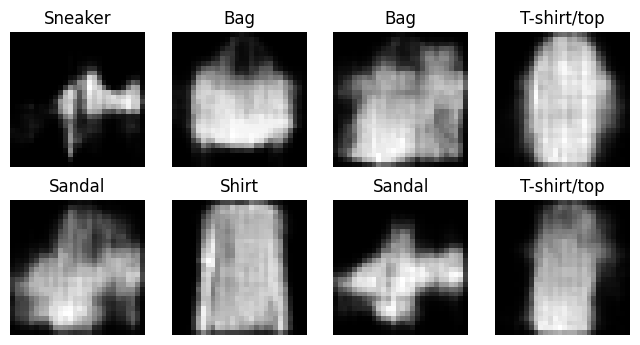

 74%|███████▎  | 5523/7500 [00:48<00:27, 73.03it/s]

1.8081207104475583e-13 0.9384007453918457


 80%|████████  | 6000/7500 [00:52<00:14, 105.32it/s]

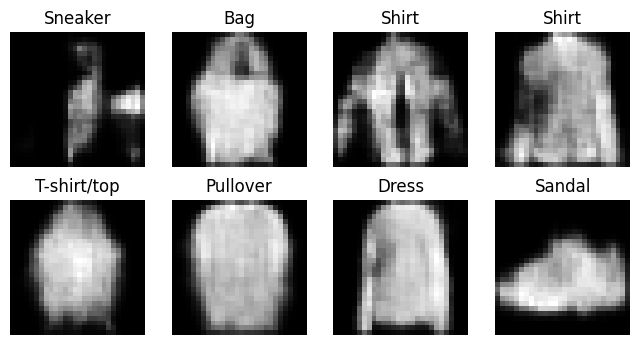

 80%|████████  | 6011/7500 [00:52<00:40, 36.84it/s] 

2.864805018643751e-14 0.9631690382957458


 87%|████████▋ | 6492/7500 [00:56<00:07, 142.10it/s]

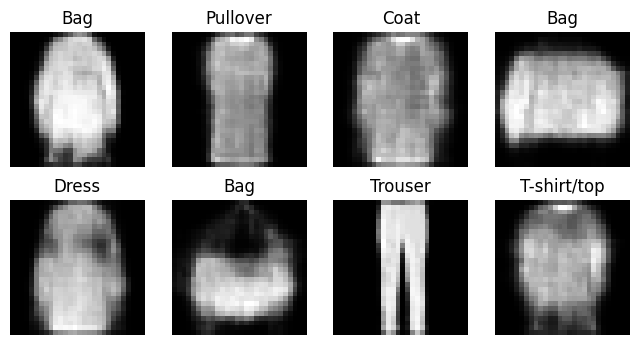

 87%|████████▋ | 6520/7500 [00:57<00:13, 73.13it/s]

3.6526684454862846e-11 0.5463773608207703


 93%|█████████▎| 6987/7500 [01:00<00:03, 136.15it/s]

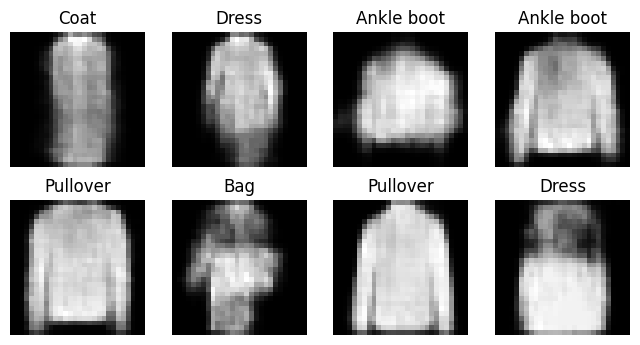

 94%|█████████▎| 7013/7500 [01:01<00:07, 68.80it/s]

5.08422060008229e-09 0.8599243760108948


100%|██████████| 7500/7500 [01:05<00:00, 114.36it/s]


  Train Loss: 2089.7597
  Testing:


100%|██████████| 1250/1250 [00:05<00:00, 243.71it/s]


  Test Loss: 2014.3318
Epoch 2/5 - Training:


  0%|          | 0/7500 [00:00<?, ?it/s]

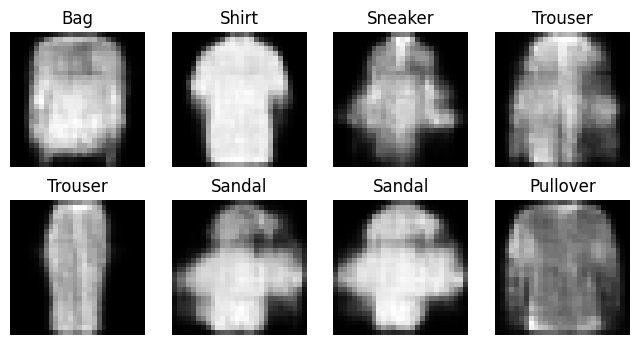

  0%|          | 15/7500 [00:00<04:11, 29.72it/s] 

2.0398286437739443e-07 0.8841772079467773


  7%|▋         | 498/7500 [00:04<00:48, 144.15it/s]

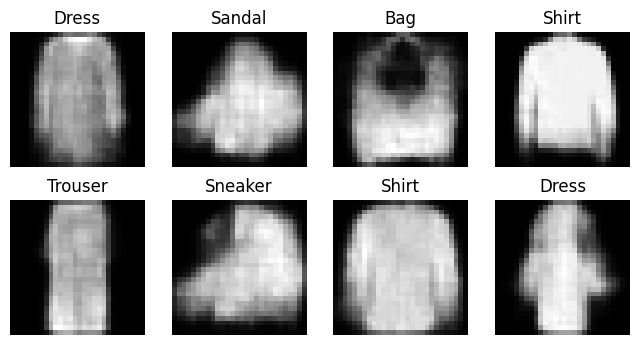

  7%|▋         | 513/7500 [00:05<02:44, 42.38it/s] 

7.507425152653013e-07 0.6994720697402954


 13%|█▎        | 992/7500 [00:09<00:45, 143.34it/s]

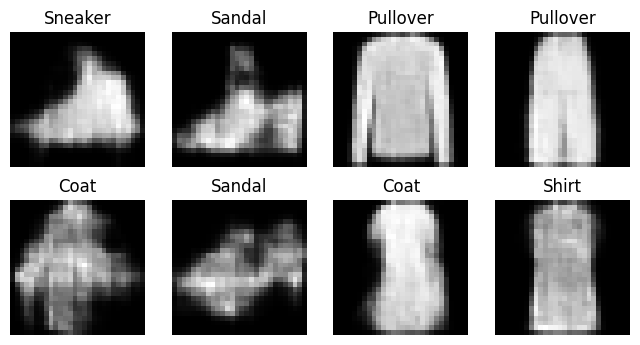

 14%|█▎        | 1022/7500 [00:09<01:27, 73.73it/s]

7.741700336350021e-11 0.9524672031402588


 20%|█▉        | 1489/7500 [00:13<00:42, 142.66it/s]

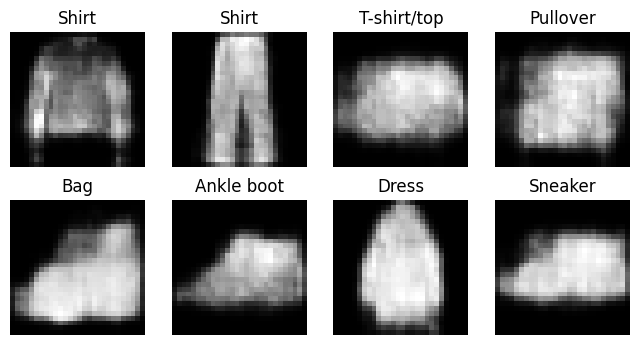

 20%|██        | 1518/7500 [00:13<01:21, 73.17it/s]

9.819049751058628e-08 0.8903024792671204


 27%|██▋       | 1998/7500 [00:17<00:51, 107.60it/s]

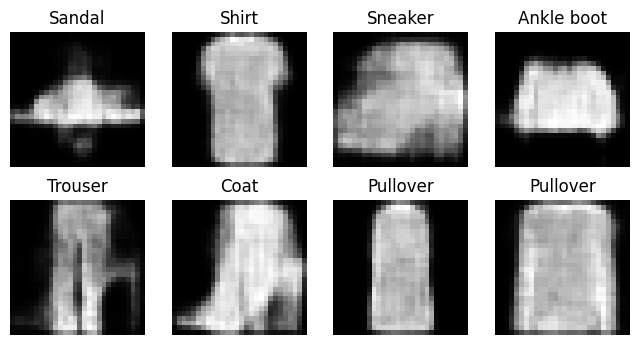

 27%|██▋       | 2009/7500 [00:18<02:26, 37.47it/s] 

3.2197689847635047e-07 0.332970529794693


 33%|███▎      | 2488/7500 [00:22<00:39, 125.79it/s]

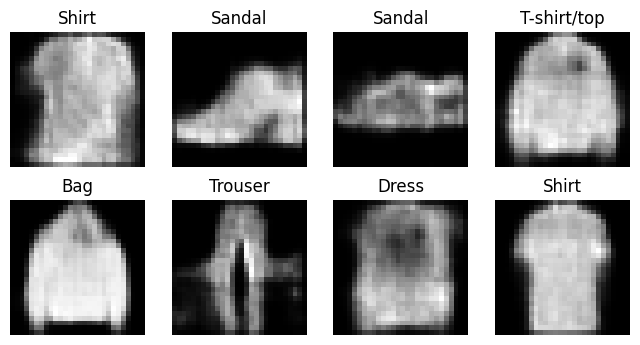

 34%|███▎      | 2515/7500 [00:23<01:14, 67.27it/s]

4.1283950849901885e-05 0.843166172504425


 40%|███▉      | 2995/7500 [00:26<00:32, 140.61it/s]

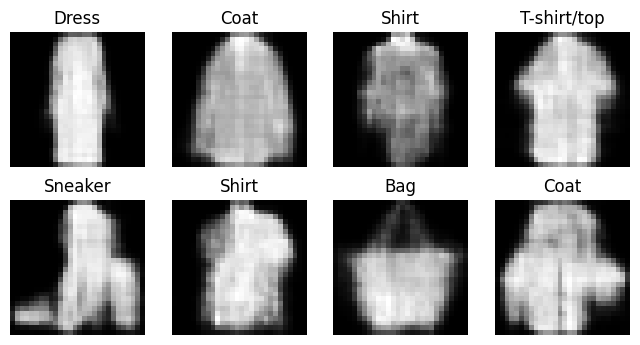

 40%|████      | 3024/7500 [00:27<01:15, 59.14it/s]

2.209444866646537e-12 0.8344680070877075


 47%|████▋     | 3489/7500 [00:31<00:33, 118.71it/s]

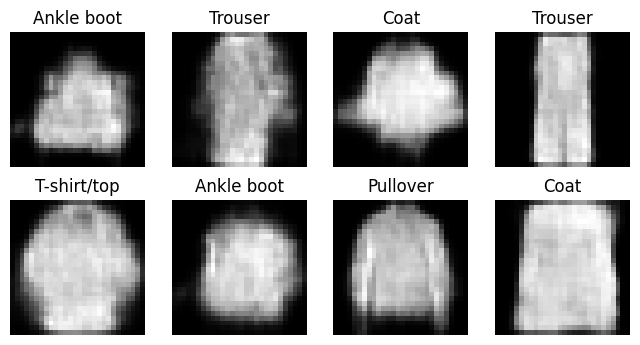

 47%|████▋     | 3514/7500 [00:32<01:03, 62.48it/s]

2.447713143283181e-09 0.8090648055076599


 53%|█████▎    | 3998/7500 [00:35<00:25, 137.51it/s]

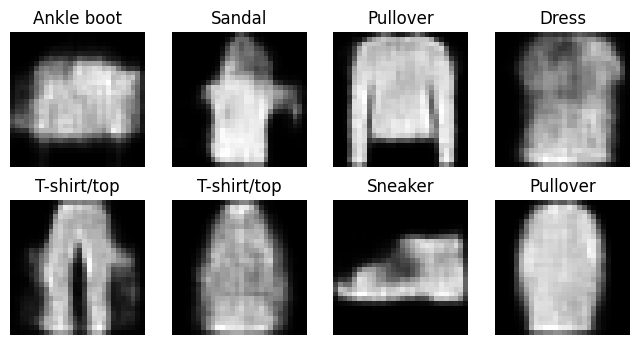

 53%|█████▎    | 4012/7500 [00:36<01:00, 57.59it/s] 

6.30439615179057e-07 0.6243864893913269


 60%|█████▉    | 4489/7500 [00:39<00:21, 137.90it/s]

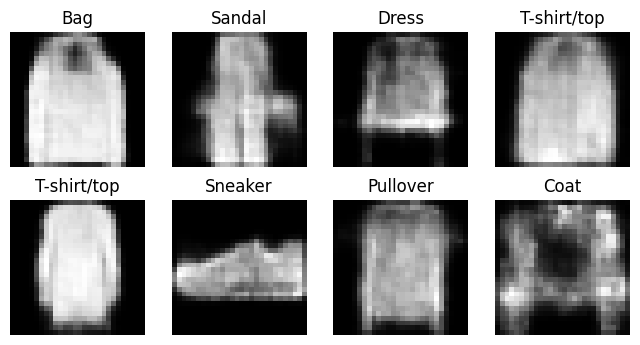

 60%|██████    | 4516/7500 [00:40<00:42, 69.88it/s]

2.7162208593445314e-10 0.8420939445495605


 67%|██████▋   | 4994/7500 [00:44<00:18, 136.87it/s]

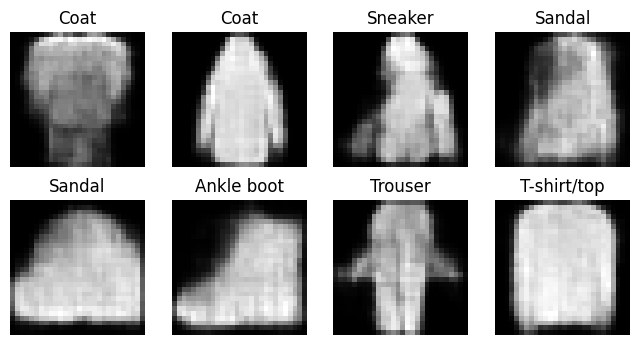

 67%|██████▋   | 5021/7500 [00:45<00:36, 68.68it/s]

7.065430054353783e-06 0.8001381158828735


 73%|███████▎  | 5491/7500 [00:48<00:14, 140.30it/s]

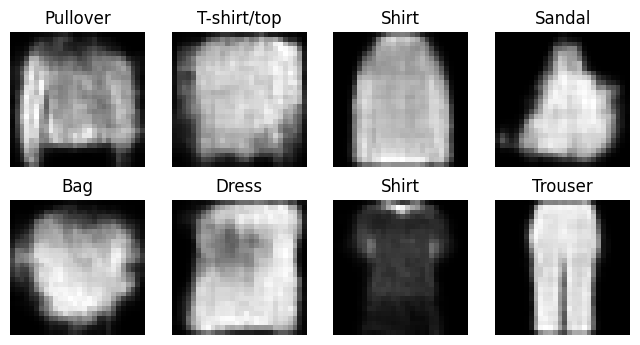

 74%|███████▎  | 5518/7500 [00:49<00:28, 69.74it/s]

1.4171172551868949e-05 0.531876266002655


 80%|███████▉  | 5989/7500 [00:52<00:10, 138.53it/s]

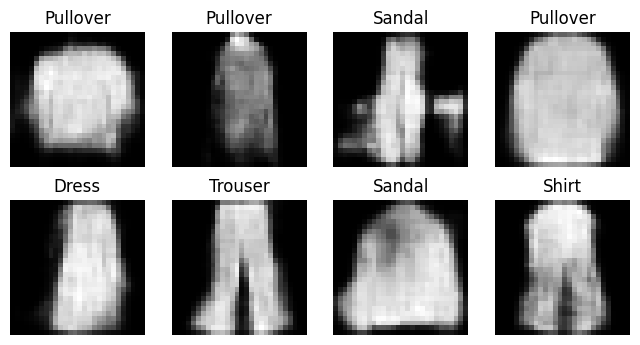

 80%|████████  | 6014/7500 [00:53<00:29, 50.90it/s]

3.533588369464269e-06 0.6419818997383118


 87%|████████▋ | 6499/7500 [00:57<00:07, 135.42it/s]

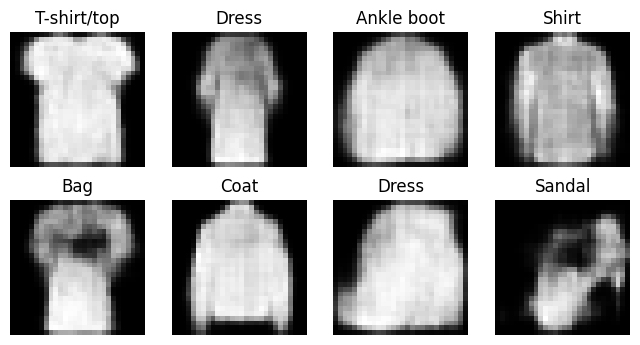

 87%|████████▋ | 6513/7500 [00:58<00:16, 58.65it/s] 

3.1681002266026326e-10 0.9606903791427612


 93%|█████████▎| 6999/7500 [01:02<00:03, 131.40it/s]

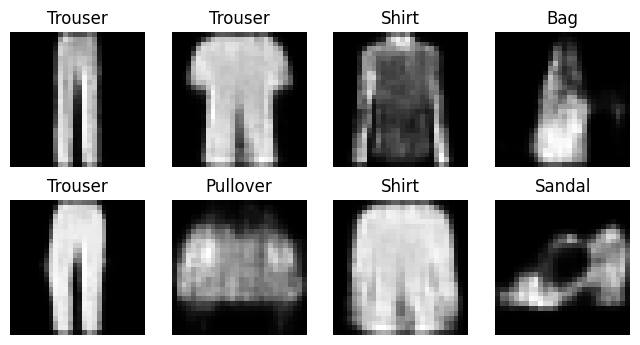

 94%|█████████▎| 7026/7500 [01:02<00:07, 66.30it/s]

4.880815939129271e-14 0.8935832381248474


100%|██████████| 7500/7500 [01:06<00:00, 112.70it/s]


  Train Loss: 1978.0794
  Testing:


100%|██████████| 1250/1250 [00:05<00:00, 218.56it/s]


  Test Loss: 1979.7479
Epoch 3/5 - Training:


  0%|          | 0/7500 [00:00<?, ?it/s]

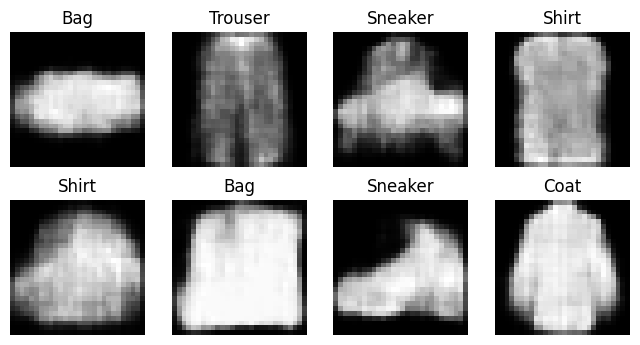

  0%|          | 15/7500 [00:00<04:26, 28.10it/s] 

4.241428896989419e-08 0.880383312702179


  7%|▋         | 490/7500 [00:04<00:51, 136.06it/s]

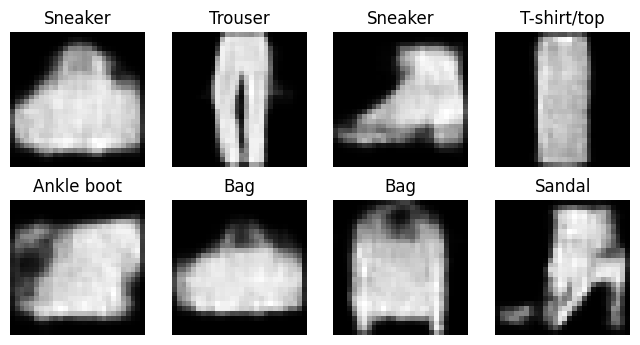

  7%|▋         | 517/7500 [00:04<01:41, 69.02it/s]

2.258491171858168e-08 0.8171790242195129


 13%|█▎        | 986/7500 [00:09<00:48, 133.31it/s]

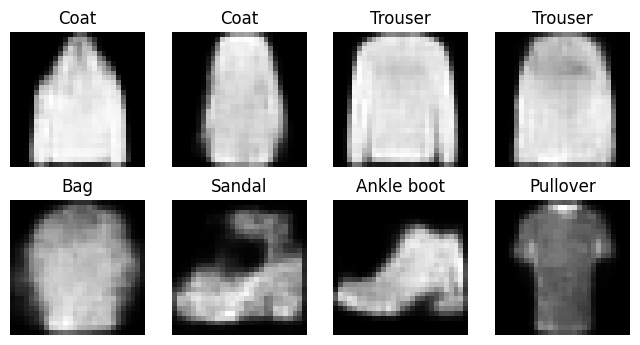

 13%|█▎        | 1012/7500 [00:10<01:37, 66.65it/s]

8.658576633457926e-11 0.9150617718696594


 20%|█▉        | 1496/7500 [00:13<00:42, 142.42it/s]

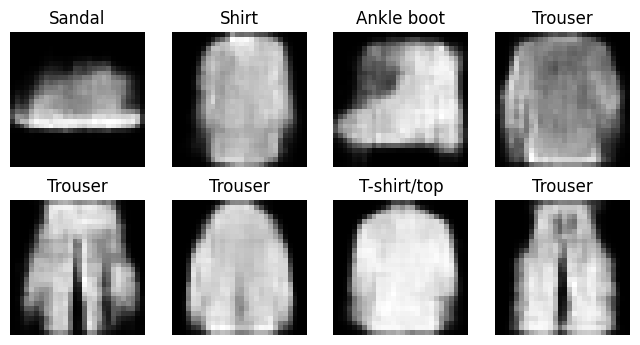

 20%|██        | 1511/7500 [00:14<02:13, 44.83it/s] 

3.7023815124825887e-09 0.9364392757415771


 27%|██▋       | 1996/7500 [00:18<00:40, 136.19it/s]

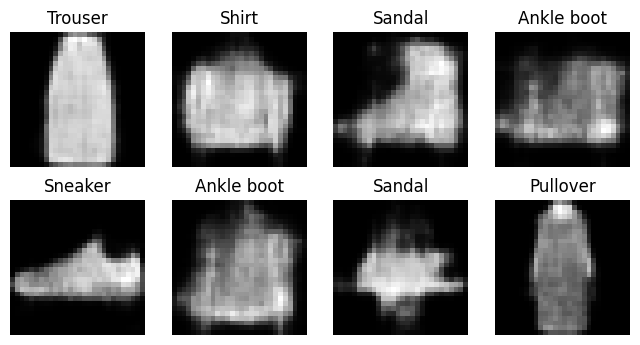

 27%|██▋       | 2010/7500 [00:18<02:02, 44.81it/s] 

1.6302343155971677e-11 0.8533956408500671


 33%|███▎      | 2487/7500 [00:23<00:38, 129.77it/s]

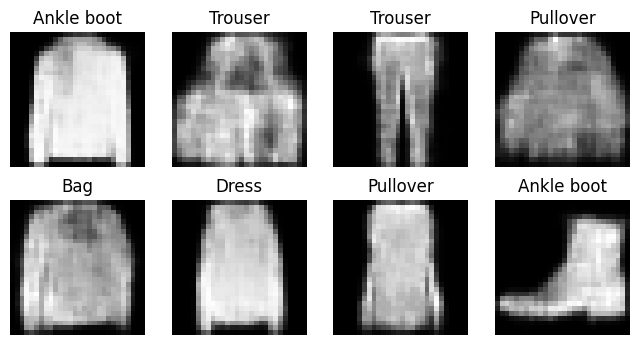

 34%|███▎      | 2513/7500 [00:23<01:14, 66.69it/s]

1.0832520302983539e-07 0.9001902341842651


 40%|███▉      | 2999/7500 [00:27<00:32, 137.50it/s]

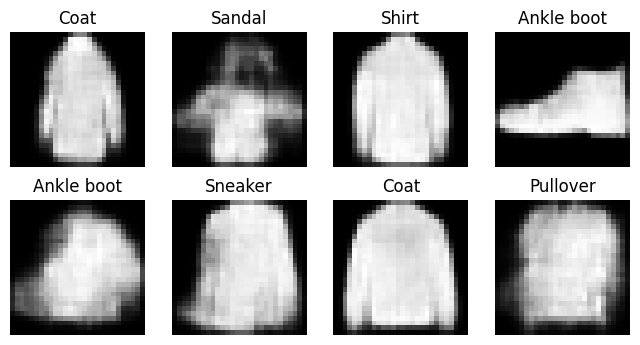

 40%|████      | 3013/7500 [00:27<01:16, 58.99it/s] 

5.31160150585297e-11 0.6614929437637329


 47%|████▋     | 3493/7500 [00:32<00:45, 88.53it/s]

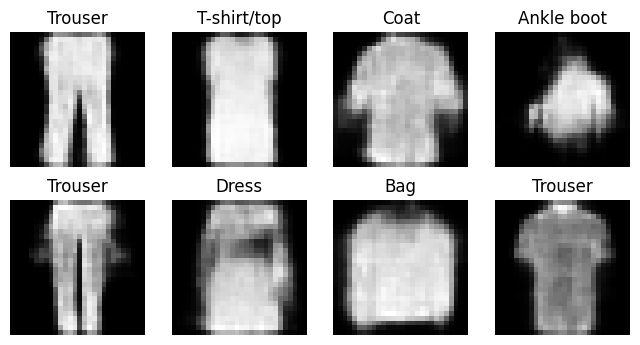

 47%|████▋     | 3514/7500 [00:32<01:34, 42.14it/s]

5.575756916291799e-18 0.6994740962982178


 53%|█████▎    | 3998/7500 [00:36<00:26, 130.91it/s]

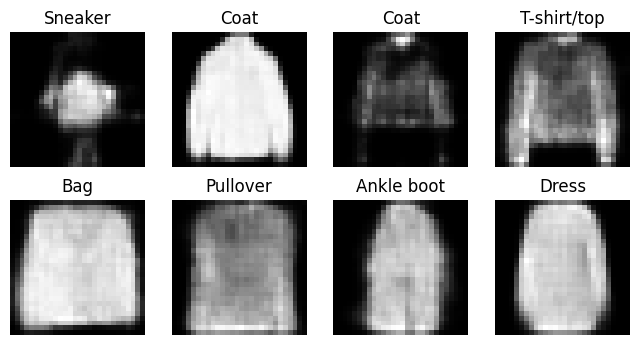

 54%|█████▎    | 4026/7500 [00:37<01:00, 57.53it/s]

1.4409728618658413e-11 0.5455325841903687


 60%|██████    | 4500/7500 [00:40<00:21, 138.72it/s]

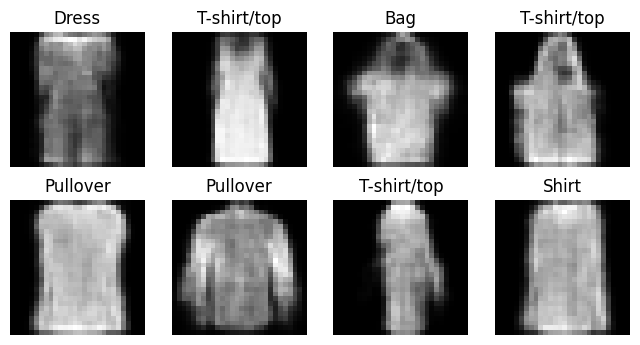

 60%|██████    | 4514/7500 [00:41<00:50, 58.90it/s] 

7.075893343477802e-11 0.8343701958656311


 67%|██████▋   | 4991/7500 [00:45<00:18, 132.58it/s]

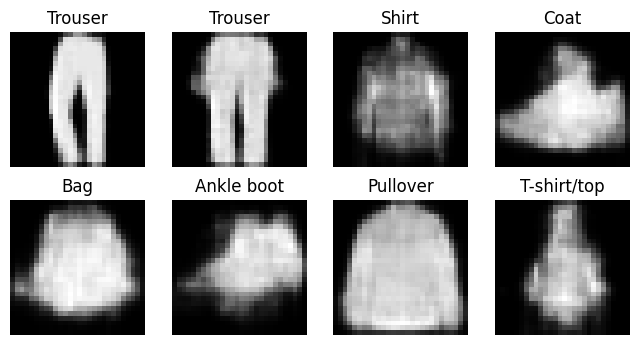

 67%|██████▋   | 5018/7500 [00:46<00:36, 67.62it/s]

2.7095790888775895e-12 0.597140371799469


 73%|███████▎  | 5487/7500 [00:50<00:15, 133.67it/s]

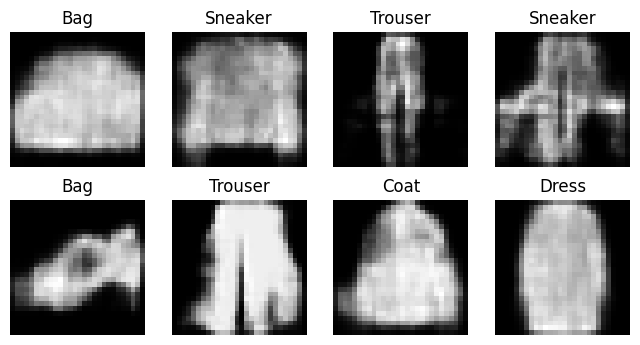

 74%|███████▎  | 5514/7500 [00:50<00:29, 66.43it/s]

5.509975380846299e-06 0.9224926233291626


 80%|███████▉  | 5998/7500 [00:54<00:10, 136.72it/s]

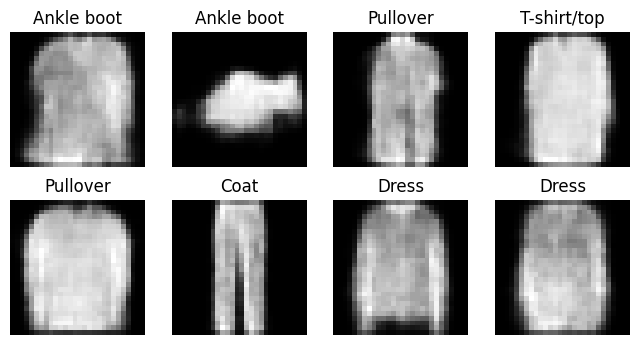

 80%|████████  | 6025/7500 [00:54<00:21, 67.91it/s]

9.958655482478207e-07 0.788860023021698


 87%|████████▋ | 6489/7500 [00:59<00:07, 132.47it/s]

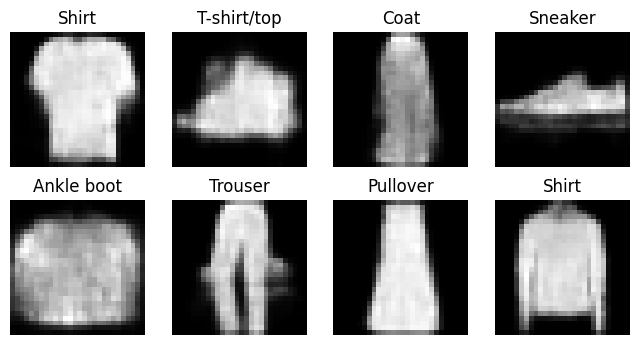

 87%|████████▋ | 6515/7500 [01:00<00:14, 66.20it/s]

2.3995828087208793e-05 0.8873767256736755


 93%|█████████▎| 6995/7500 [01:03<00:03, 131.84it/s]

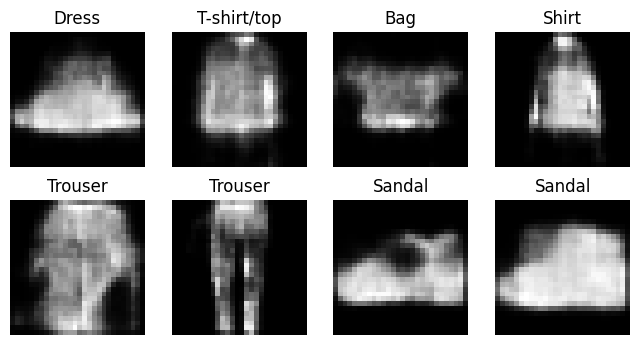

 94%|█████████▎| 7022/7500 [01:04<00:08, 54.15it/s]

2.61528072087458e-07 0.7761737704277039


100%|██████████| 7500/7500 [01:08<00:00, 109.78it/s]


  Train Loss: 1953.9228
  Testing:


100%|██████████| 1250/1250 [00:05<00:00, 221.13it/s]


  Test Loss: 1961.2816
Epoch 4/5 - Training:


  0%|          | 0/7500 [00:00<?, ?it/s]

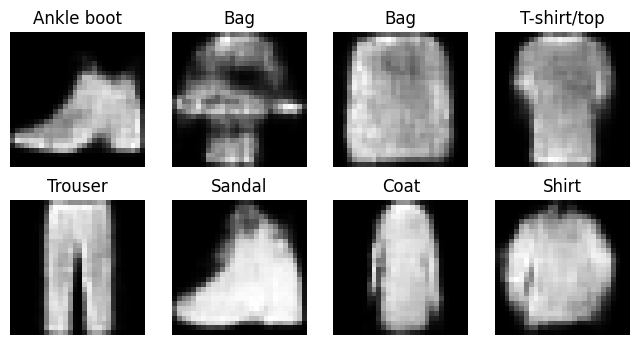

  0%|          | 13/7500 [00:00<05:19, 23.45it/s] 

2.1479729453433016e-11 0.7753931879997253


  7%|▋         | 492/7500 [00:04<00:50, 137.63it/s]

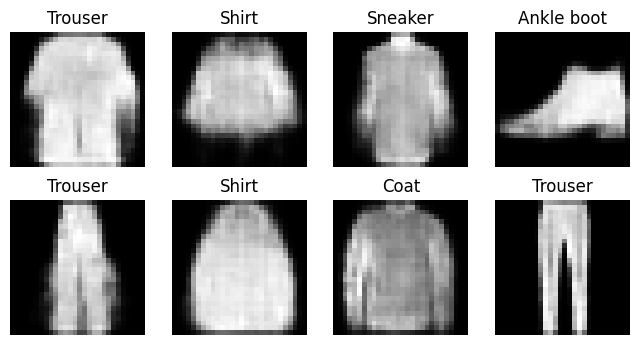

  7%|▋         | 518/7500 [00:04<01:47, 64.83it/s]

3.5264415600977372e-06 0.5704795718193054


 13%|█▎        | 997/7500 [00:09<00:49, 130.68it/s]

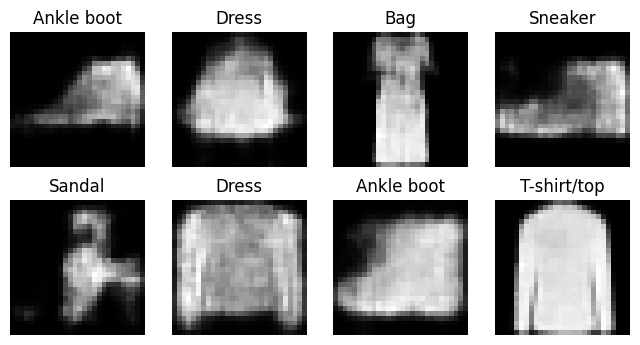

 14%|█▎        | 1025/7500 [00:10<01:33, 69.17it/s]

2.194781467679263e-09 0.7473028302192688


 20%|█▉        | 1491/7500 [00:13<00:45, 131.49it/s]

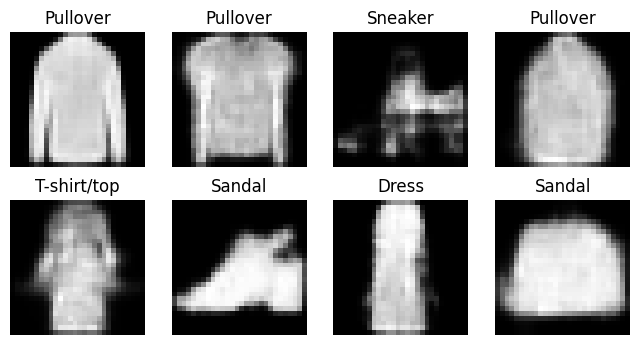

 20%|██        | 1519/7500 [00:14<01:26, 68.76it/s]

8.701278031431059e-10 0.964979887008667


 27%|██▋       | 1990/7500 [00:18<00:43, 127.81it/s]

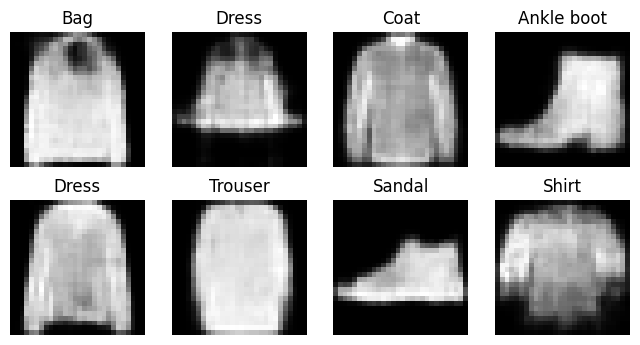

 27%|██▋       | 2013/7500 [00:19<02:20, 39.07it/s]

5.127701596663314e-10 0.8627648949623108


 33%|███▎      | 2488/7500 [00:23<00:38, 131.13it/s]

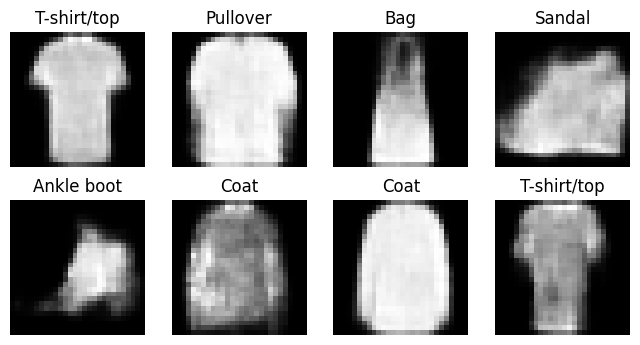

 34%|███▎      | 2513/7500 [00:23<01:16, 64.93it/s]

1.9951698959630448e-07 0.3940865695476532


 40%|███▉      | 2992/7500 [00:27<00:35, 128.71it/s]

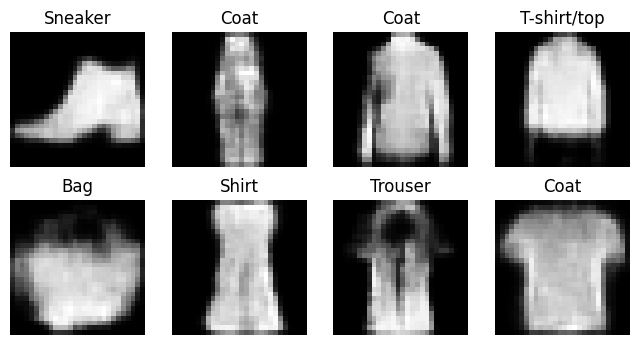

 40%|████      | 3017/7500 [00:28<01:09, 64.61it/s]

2.0437098680048393e-09 0.7778562307357788


 47%|████▋     | 3497/7500 [00:32<00:41, 95.56it/s]

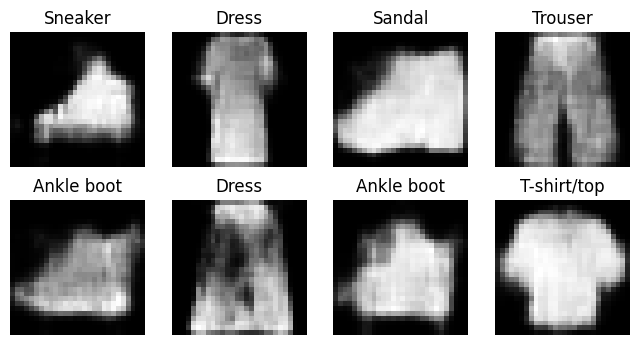

 47%|████▋     | 3521/7500 [00:33<01:25, 46.80it/s]

1.1749856729942332e-13 0.7970373630523682


 53%|█████▎    | 3988/7500 [00:36<00:25, 136.93it/s]

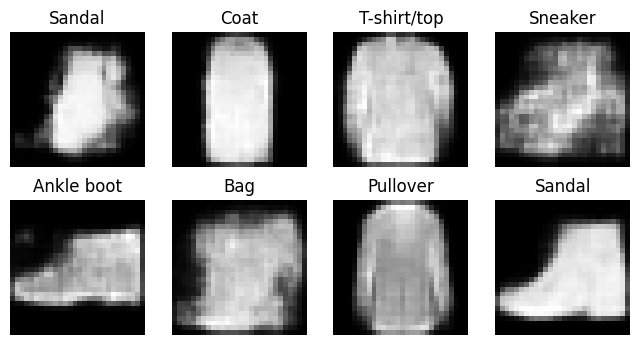

 54%|█████▎    | 4013/7500 [00:37<00:53, 64.82it/s]

2.4254279140656365e-10 0.7323711514472961


 60%|█████▉    | 4495/7500 [00:40<00:22, 135.84it/s]

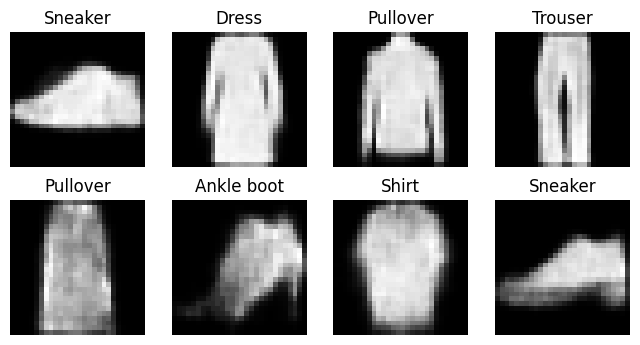

 60%|██████    | 4523/7500 [00:41<00:41, 71.11it/s]

7.276214741835929e-09 0.837079644203186


 67%|██████▋   | 4997/7500 [00:45<00:19, 129.94it/s]

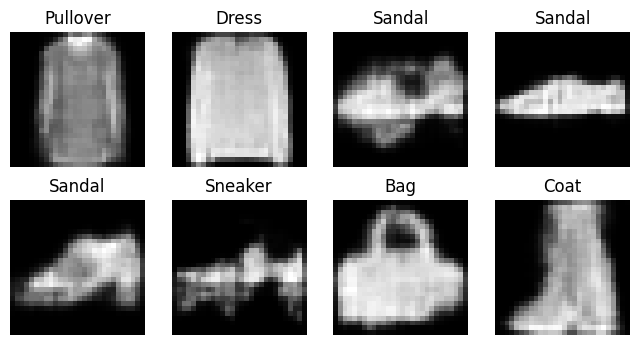

 67%|██████▋   | 5026/7500 [00:46<00:43, 57.28it/s]

5.826553017840297e-09 0.5986925363540649


 73%|███████▎  | 5497/7500 [00:50<00:14, 134.09it/s]

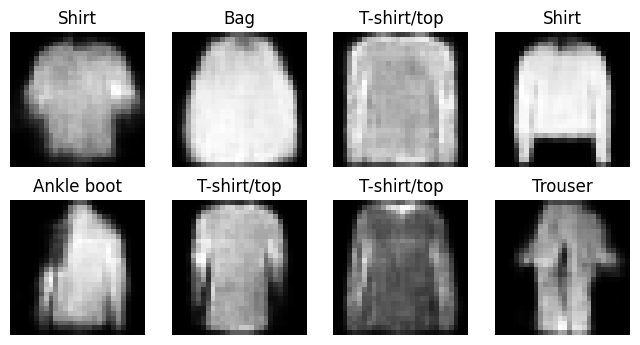

 74%|███████▎  | 5524/7500 [00:50<00:28, 69.78it/s]

5.522163519344758e-06 0.7891395092010498


 80%|███████▉  | 5999/7500 [00:54<00:11, 135.70it/s]

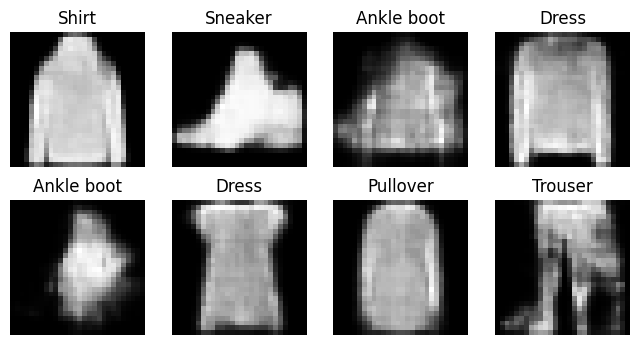

 80%|████████  | 6025/7500 [00:55<00:21, 69.86it/s]

8.730000056189624e-11 0.8702163696289062


 87%|████████▋ | 6500/7500 [00:59<00:07, 138.45it/s]

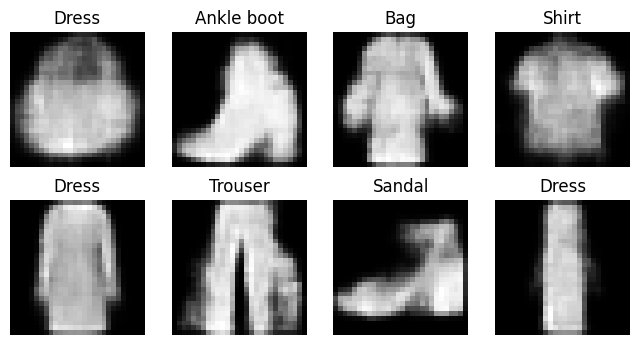

 87%|████████▋ | 6514/7500 [00:59<00:16, 58.69it/s] 

5.957298299108515e-07 0.946436882019043


 93%|█████████▎| 6988/7500 [01:03<00:03, 135.47it/s]

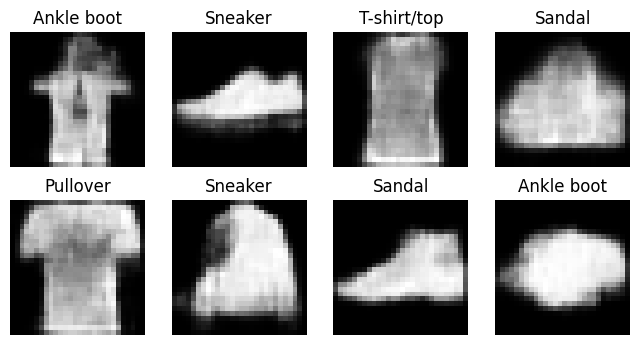

 94%|█████████▎| 7013/7500 [01:04<00:07, 65.15it/s]

3.586220653772898e-09 0.8390988707542419


100%|██████████| 7500/7500 [01:08<00:00, 110.15it/s]


  Train Loss: 1941.0932
  Testing:


100%|██████████| 1250/1250 [00:05<00:00, 208.59it/s]


  Test Loss: 1945.4313
Epoch 5/5 - Training:


  0%|          | 0/7500 [00:00<?, ?it/s]

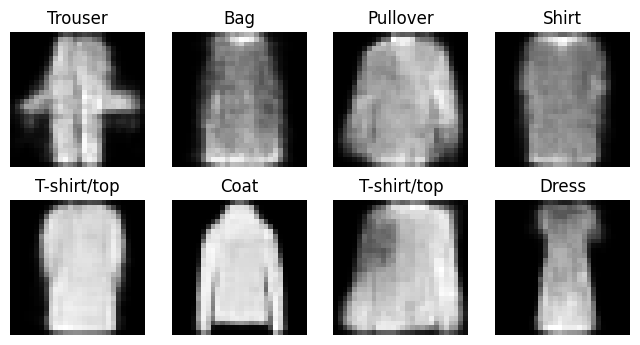

  0%|          | 13/7500 [00:00<05:08, 24.26it/s] 

5.198062869027353e-09 0.9266223907470703


  7%|▋         | 494/7500 [00:04<00:54, 129.37it/s]

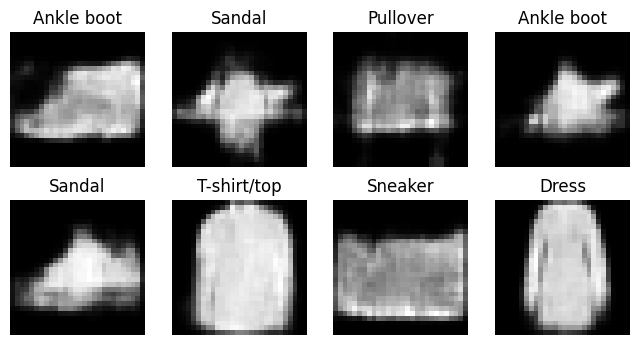

  7%|▋         | 521/7500 [00:05<02:17, 50.77it/s]

8.855983307798354e-11 0.8189265131950378


 13%|█▎        | 989/7500 [00:09<00:51, 126.87it/s]

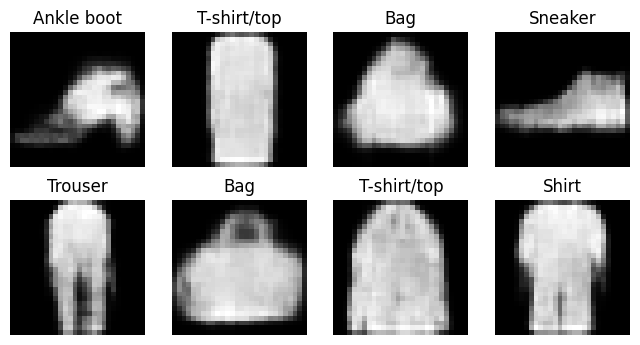

 14%|█▎        | 1014/7500 [00:10<01:40, 64.74it/s]

7.170327699645984e-12 0.9011504650115967


 20%|█▉        | 1496/7500 [00:14<00:46, 129.42it/s]

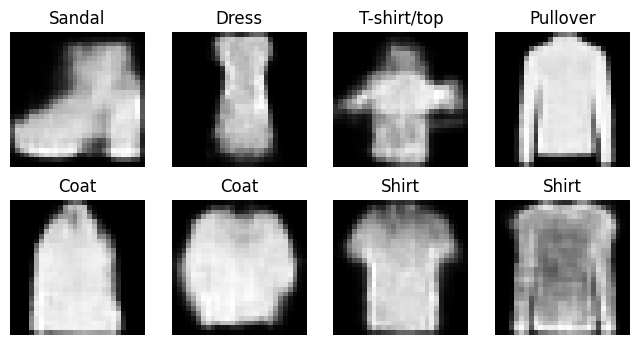

 20%|██        | 1521/7500 [00:14<01:35, 62.42it/s]

2.9832929158146726e-06 0.8904736042022705


 27%|██▋       | 1996/7500 [00:18<00:40, 134.31it/s]

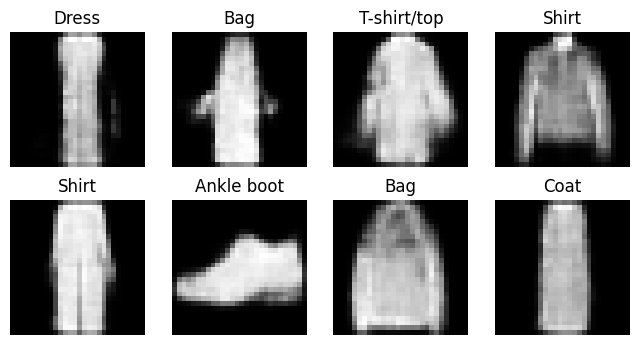

 27%|██▋       | 2010/7500 [00:19<01:40, 54.53it/s] 

4.814094285665279e-16 0.8120315074920654


 33%|███▎      | 2491/7500 [00:23<00:36, 137.85it/s]

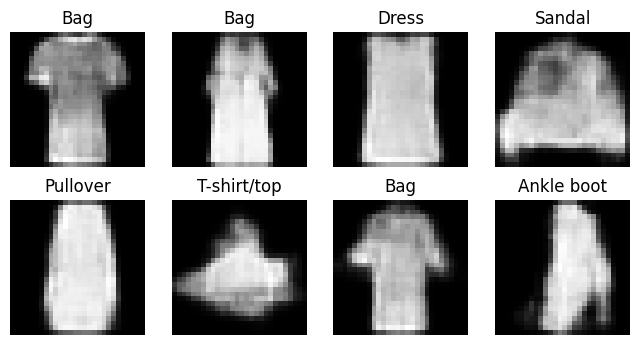

 34%|███▎      | 2517/7500 [00:24<01:13, 67.83it/s]

2.354723971365047e-09 0.8867499828338623


 40%|████      | 3000/7500 [00:27<00:33, 135.29it/s]

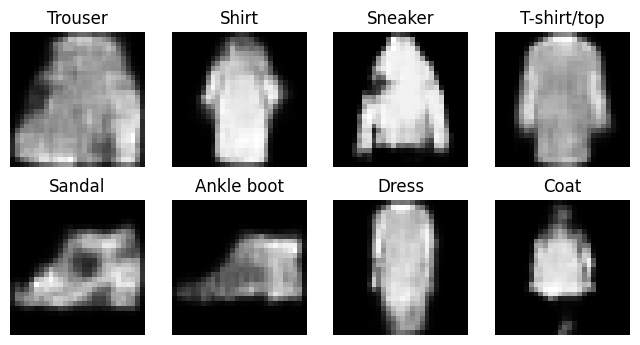

 40%|████      | 3014/7500 [00:28<01:35, 47.13it/s] 

6.519001090055099e-07 0.892896294593811


 47%|████▋     | 3492/7500 [00:32<00:39, 100.96it/s]

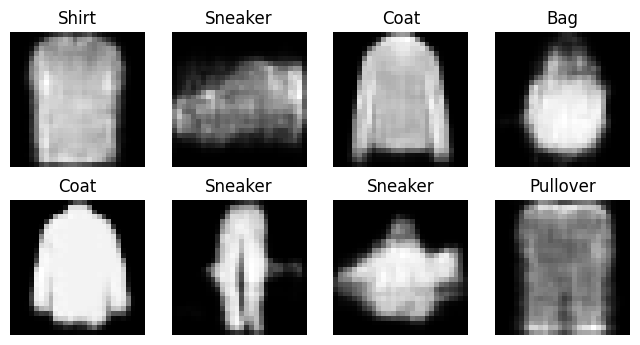

 47%|████▋     | 3512/7500 [00:33<01:34, 41.98it/s]

6.929058571358837e-08 0.6247724890708923


 53%|█████▎    | 3997/7500 [00:37<00:26, 129.91it/s]

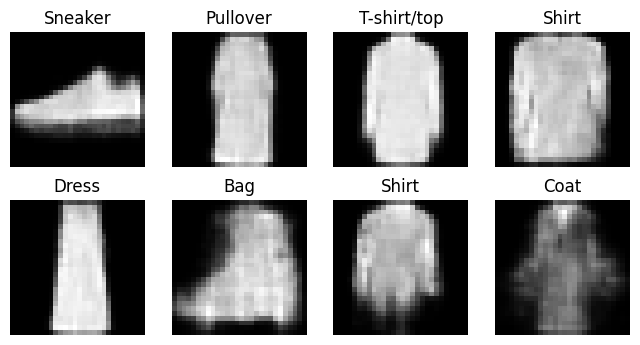

 54%|█████▎    | 4024/7500 [00:37<00:51, 67.80it/s]

1.8063828211012378e-10 0.955069363117218


 60%|█████▉    | 4497/7500 [00:41<00:22, 133.67it/s]

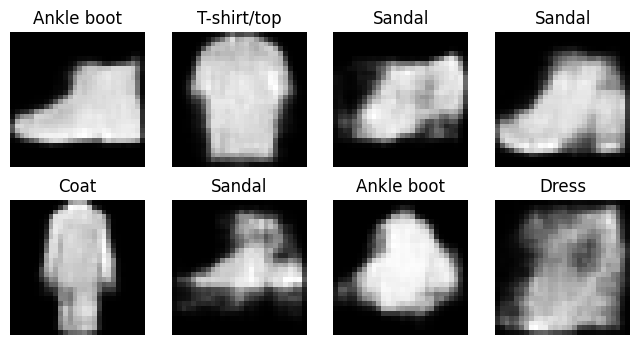

 60%|██████    | 4523/7500 [00:42<00:44, 67.33it/s]

3.1557731428044633e-10 0.7262536287307739


 67%|██████▋   | 4993/7500 [00:46<00:25, 100.02it/s]

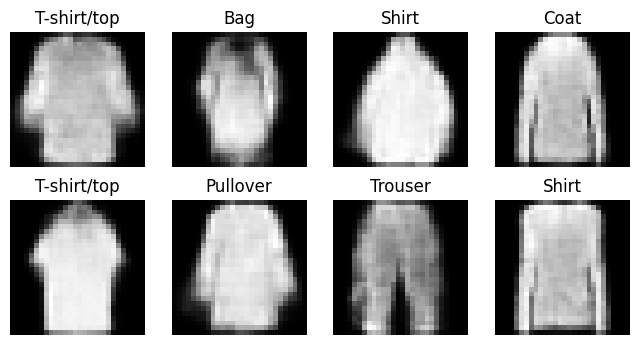

 67%|██████▋   | 5017/7500 [00:47<00:43, 57.40it/s]

1.3496612609742442e-06 0.8691905736923218


 73%|███████▎  | 5488/7500 [00:50<00:15, 133.58it/s]

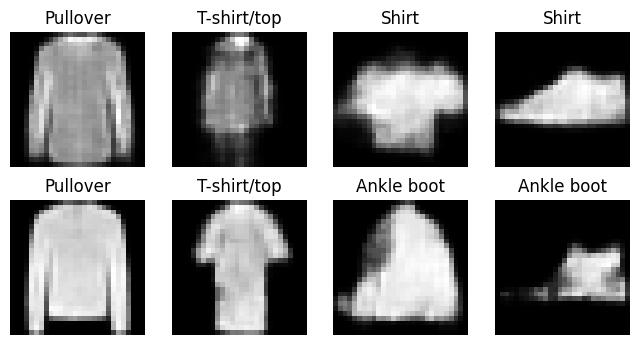

 74%|███████▎  | 5513/7500 [00:51<00:29, 66.68it/s]

1.9718045223271474e-06 0.2631452679634094


 80%|████████  | 6000/7500 [00:55<00:12, 124.75it/s]

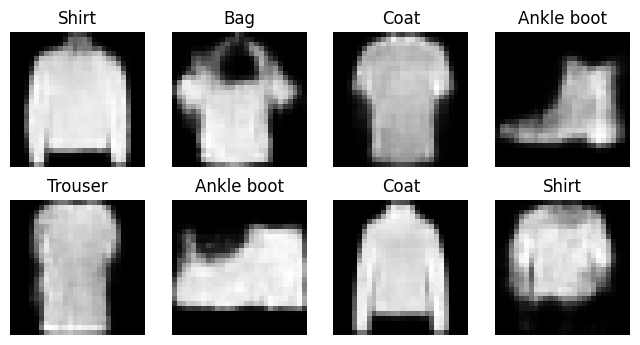

 80%|████████  | 6013/7500 [00:56<00:36, 40.52it/s] 

1.0763098998722853e-06 0.8564398288726807


 87%|████████▋ | 6496/7500 [01:00<00:08, 124.48it/s]

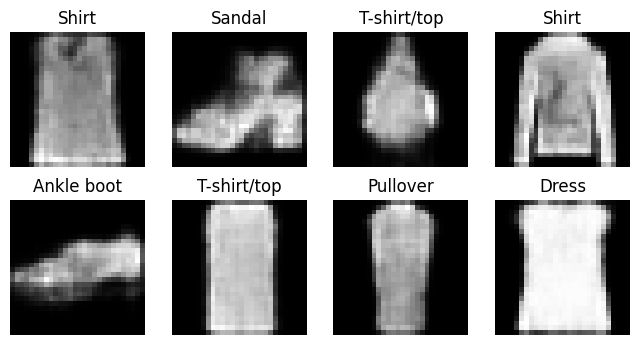

 87%|████████▋ | 6521/7500 [01:01<00:15, 62.98it/s]

3.316949850635381e-14 0.9392901659011841


 93%|█████████▎| 6992/7500 [01:04<00:04, 119.10it/s]

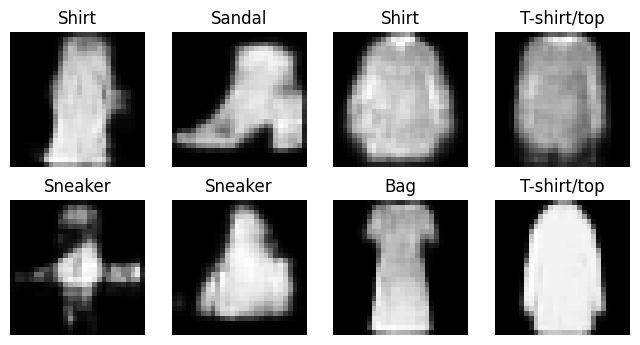

 94%|█████████▎| 7018/7500 [01:05<00:07, 64.89it/s]

9.988062894122907e-13 0.7719466090202332


100%|██████████| 7500/7500 [01:09<00:00, 107.88it/s]


  Train Loss: 1931.9402
  Testing:


100%|██████████| 1250/1250 [00:06<00:00, 206.63it/s]

  Test Loss: 1945.8221


In [26]:
# torch.manual_seed(42)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LATENT_DIMS = 8

encoder = Encoder(1)
enc = encoder(imgs)
latentspace = LatentSpace(np.prod(encoder.out_shape), LATENT_DIMS)
decoder = Decoder(LATENT_DIMS, encoder.out_shape)
cvae = ConditionalVAE(encoder, decoder, latentspace, classes)
optimizer = optim.Adam(cvae.parameters())
metric_fn = lambda x: x # identity metric
results = train(cvae, trainloader, testloader, loss_fn, optimizer, device, 5, metric_fn)